In [21]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
print(df.head())
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])] # Remove partner,cntry,idno
print(X.head())

  cntry  idno  year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  \
0    CH   5.0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   
1    CH  25.0     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   
2    CH  26.0     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   
3    CH  28.0     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   
4    CH  29.0     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   

   gndr  agea  partner  
0   2.0  60.0      1.0  
1   2.0  59.0      1.0  
2   1.0  24.0      2.0  
3   2.0  64.0      1.0  
4   2.0  55.0      1.0  
   year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  gndr  agea
0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   2.0  60.0
1     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   2.0  59.0
2     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   1.0  24.0
3     6    4.0      6.0      6.0     7.0   10.0      6.0     

In [3]:
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)
print(offset)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

7332


Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [4]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
print(table_test.head())

col_0    0.0  1.0  All
partner               
0.0      454   51  505
1.0      151  159  310
All      605  210  815


In [5]:
# Make aprintable output
train_tI_errors0 = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors0 = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors0 = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors0 = table_test.loc[1.0,0.0]/table_test.loc['All','All']

Scores0= cross_val_score(clf,X,y)

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Mean Score over 3 folds'
).format(train_tI_errors0, train_tII_errors0, test_tI_errors0, test_tII_errors0, np.mean(Scores0)))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191
Mean Score over 3 folds


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

In [6]:
feature_importance = clf.feature_importances_
feature_importance

array([0.01497972, 0.08405402, 0.08240387, 0.07755603, 0.05077273,
       0.15597497, 0.04937004, 0.03993169, 0.05940057, 0.27498497,
       0.01505447, 0.01558719, 0.00600491, 0.03773901, 0.02324548,
       0.01294032])

In [7]:
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
print(sorted_idx)

[12 15  0 10 11 14 13  7  6  4  8  3  2  1  5  9]


In [8]:
sorted_idx.shape[0]

16

In [9]:
#Values are generated within the half-open interval [start, stop) 
#(in other words, the interval including start but excluding stop)
pos = np.arange(sorted_idx.shape[0]) + .5
pos

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5])

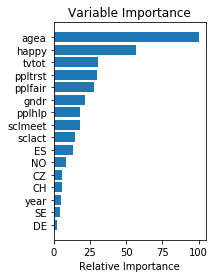

In [10]:
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

### First trial - allowing more leaves 10 instead of 2

In [11]:
# that might probably lead to overfitting
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)
print(offset)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 10,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
print(table_test.head())

# Make aprintable output
train_tI_errors1 = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors1 = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors1 = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors1 = table_test.loc[1.0,0.0]/table_test.loc['All','All']

Scores1=cross_val_score(clf,X,y)

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Average score of 3 crossvalidations on test data: {}'
).format(train_tI_errors1, train_tII_errors1, test_tI_errors1, test_tII_errors1,np.mean(Scores1)))


7332
col_0    0.0  1.0  All
partner               
0.0      419   86  505
1.0      150  160  310
All      569  246  815
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.10552147239263804
Percent Type II errors: 0.18404907975460122
Average score of 3 crossvalidations on test data: 0.6854112817119026


As expected that led to overfitting (training set is predicted correctly, but test set has even higher Type 1 error rate than with 2 leaves).

### Second trial - 5 leaves

In [12]:
# that might probably lead to overfitting
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)
print(offset)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
print(table_test.head())

# Make aprintable output
train_tI_errors2 = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors2 = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors2 = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors2 = table_test.loc[1.0,0.0]/table_test.loc['All','All']

Scores2=cross_val_score(clf,X,y)

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Average score of 3 crossvalidations on test data: {}'
).format(train_tI_errors2, train_tII_errors2, test_tI_errors2, test_tII_errors2,np.mean(Scores2)))

7332
col_0    0.0  1.0  All
partner               
0.0      420   85  505
1.0      141  169  310
All      561  254  815
Training set accuracy:
Percent Type I errors: 0.0061374795417348605
Percent Type II errors: 0.06860338243316967

Test set accuracy:
Percent Type I errors: 0.10429447852760736
Percent Type II errors: 0.17300613496932515
Average score of 3 crossvalidations on test data: 0.6728918325888195


Looks better with 5 leaves.
### Third trial - add features

In [13]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [14]:
df['sad']= 10-df['happy']
df['tvtot+sad']= df['tvtot']+ df['sad']
df['trst_fair_help']=df['ppltrst'] +df['pplfair']+df['pplhlp']
df['social']=df['sclmeet']+ df['sclact']

In [15]:
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])] # Remove partner,cntry,idno
print(X.head())

   year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  gndr  agea  \
0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   2.0  60.0   
1     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   2.0  59.0   
2     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   1.0  24.0   
3     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   2.0  64.0   
4     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   2.0  55.0   

   sad  tvtot+sad  trst_fair_help  social  
0  2.0        5.0            18.0     9.0  
1  1.0        7.0            17.0     5.0  
2  3.0        4.0            24.0     9.0  
3  0.0        4.0            19.0     8.0  
4  2.0        7.0            18.0     9.0  


In [16]:
# that might probably lead to overfitting
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)
print(offset)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
print(table_test.head())

# Make aprintable output
train_tI_errors3 = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors3 = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors3 = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors3 = table_test.loc[1.0,0.0]/table_test.loc['All','All']

Scores3=cross_val_score(clf,X,y)

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Average score of 3 crossvalidations on test data: {}'
).format(train_tI_errors3, train_tII_errors3, test_tI_errors3, test_tII_errors3,np.mean(Scores3)))

7332
col_0    0.0  1.0  All
partner               
0.0      455   50  505
1.0      150  160  310
All      605  210  815
Training set accuracy:
Percent Type I errors: 0.04569012547735952
Percent Type II errors: 0.17321331151118385

Test set accuracy:
Percent Type I errors: 0.06134969325153374
Percent Type II errors: 0.18404907975460122
Average score of 3 crossvalidations on test data: 0.685290812419593


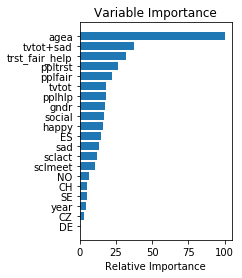

In [17]:
feature_importance = clf.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Combining the weaker features did not help the models accurancy, eventhough the new features were used as important classifiers.

### Fourth trial - change train - test to 50:50,3

In [18]:
# that might probably lead to overfitting
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.5)
print(offset)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
print(table_test.head())

# Make aprintable output
train_tI_errors4 = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors4 = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors4 = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors4 = table_test.loc[1.0,0.0]/table_test.loc['All','All']

Scores4=cross_val_score(clf,X,y)

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Average score of 3 crossvalidations on test data: {}'
).format(train_tI_errors4, train_tII_errors4, test_tI_errors4, test_tII_errors4,np.mean(Scores4)))

4073
col_0     0.0   1.0   All
partner                  
0.0      2162   347  2509
1.0       744   821  1565
All      2906  1168  4074
Training set accuracy:
Percent Type I errors: 0.0007365578197888534
Percent Type II errors: 0.018904984041247238

Test set accuracy:
Percent Type I errors: 0.08517427589592538
Percent Type II errors: 0.18262150220913106
Average score of 3 crossvalidations on test data: 0.6764510786183053


### Fifths trial: Loss function set to ‘exponential’

In [19]:
# that might probably lead to overfitting
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.5)
print(offset)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
print(table_test.head())

# Make aprintable output
train_tI_errors5 = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors5 = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors5 = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors5 = table_test.loc[1.0,0.0]/table_test.loc['All','All']

Scores5=cross_val_score(clf,X,y)

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Average score of 3 crossvalidations on test data: {}'
).format(train_tI_errors5, train_tII_errors5, test_tI_errors5, test_tII_errors5,np.mean(Scores5)))

4073
col_0     0.0   1.0   All
partner                  
0.0      2176   333  2509
1.0       741   824  1565
All      2917  1157  4074
Training set accuracy:
Percent Type I errors: 0.0004910385465259023
Percent Type II errors: 0.02332433095998036

Test set accuracy:
Percent Type I errors: 0.0817378497790869
Percent Type II errors: 0.18188512518409425
Average score of 3 crossvalidations on test data: 0.6771879528899521


### Results


          0         1         2         3         4         5
0  0.613034  0.609352  0.599043  0.618925  0.603829  0.607879
1  0.690353  0.715758  0.696981  0.687408  0.702135  0.696244
2  0.753591  0.731123  0.722652  0.749540  0.723389  0.727440


Text(0.5,0,'Versions tried')

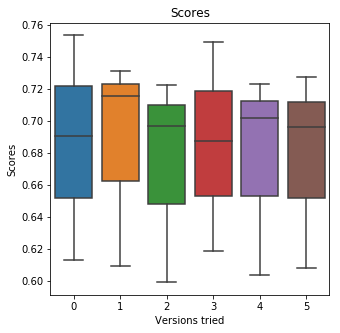

In [22]:
Scores = {'0': Scores0,'1': Scores1,'2':Scores2,'3':Scores3,'4':Scores4,'5':Scores5}
Scoreresults = pd.DataFrame(data=Scores, index=(range(3)))
print(Scoreresults.head())


# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
im.set_title('Scores')
im.set_ylabel('Scores')
im.set_xlabel('Versions tried')

None of the changes I made, resulted in a increase of score or reduction in variance. 